# Example: Reachability problem solved by [Lazy ellipsoid abstraction](https://github.com/dionysos-dev/Dionysos.jl/blob/master/docs/src/manual/manual.md#solvers).

In [1]:
using StaticArrays, LinearAlgebra, Plots
using JuMP, Clarabel

import Random
Random.seed!(0)

using Dionysos
const DI = Dionysos
const UT = DI.Utils
const DO = DI.Domain
const ST = DI.System
const SY = DI.Symbolic
const PR = DI.Problem
const OP = DI.Optim
const AB = OP.Abstraction

include(joinpath(dirname(dirname(pathof(Dionysos))), "problems", "non_linear.jl"))

Main.var"##293".NonLinear

# First example

In [2]:
concrete_problem = NonLinear.problem()
concrete_system = concrete_problem.system

Dionysos.System.SymbolicSystem(Main.var"##293".NonLinear.var"#5#6"(), SymbolicUtils.BasicSymbolic{Real}[1.1px - 0.2py + vx - 5.0e-5(py^3), 0.2px + 1.1py + vy + 5.0e-5(px^3)], 1.0, 2, 2, 2, Symbolics.Num[px, py], Symbolics.Num[vx, vy], Symbolics.Num[wx, wy], [-1, 1]², [-20, 20]², [0, 0]¹, [-20, 20]², Dionysos.Utils.HyperRectangle{StaticArraysCore.SVector{2, Float64}}([-10.0, -10.0], [10.0, 10.0]), Dionysos.Utils.HyperRectangle{StaticArraysCore.SVector{2, Float64}}([0.0, 0.0], [0.0, 0.0]), Dionysos.Utils.Ellipsoid{Float64, Matrix{Float64}, Vector{Float64}}[Dionysos.Utils.Ellipsoid{Float64, Matrix{Float64}, Vector{Float64}}([0.02 0.0; 0.0 0.02], [0.0, 0.0])], Main.var"##293".NonLinear.var"#f_eval#2"{Float64, Float64}(1.0, 5.0e-5), Main.var"##293".NonLinear.var"#f_backward_eval#3"{Float64, Float64}(1.0, 5.0e-5), [[0.1 0.0; 0.0 0.0], [0.0 0.0; 0.0 0.1]], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0])

Optimizer's parameters

In [3]:
sdp_opt = optimizer_with_attributes(Clarabel.Optimizer, MOI.Silent() => true)

maxδx = 100
maxδu = 10 * 2
λ = 0.01
k1 = 1
k2 = 1
RRTstar = false
continues = false
maxIter = 100

optimizer = MOI.instantiate(AB.LazyEllipsoidsAbstraction.Optimizer)
AB.LazyEllipsoidsAbstraction.set_optimizer!(
    optimizer,
    concrete_problem,
    sdp_opt,
    maxδx,
    maxδu,
    λ,
    k1,
    k2,
    RRTstar,
    continues,
    maxIter,
)

compute_transition (generic function with 1 method)

Build the state feedback abstraction and solve the optimal control problem using RRT algorithm.

In [4]:
MOI.optimize!(optimizer)

Iterations2Go:	100
	Closest Dist: 28.284271247461902
Iterations2Go:	99
	Closest Dist: 21.96504288572114
Iterations2Go:	98
	Closest Dist: 21.96504288572114
Iterations2Go:	97
	Closest Dist: 21.96504288572114
Iterations2Go:	96
	Closest Dist: 21.96504288572114
Iterations2Go:	95
	Closest Dist: 21.96504288572114
Iterations2Go:	94
	Closest Dist: 21.96504288572114
Iterations2Go:	93
	Closest Dist: 21.96504288572114
Iterations2Go:	92
	Closest Dist: 21.96504288572114
Iterations2Go:	91
	Closest Dist: 21.96504288572114
Iterations2Go:	90
	Closest Dist: 21.96504288572114
Iterations2Go:	89
	Closest Dist: 21.96504288572114
Iterations2Go:	88
	Closest Dist: 21.96504288572114
Iterations2Go:	87
	Closest Dist: 21.96504288572114
Iterations2Go:	86
	Closest Dist: 21.96504288572114
Iterations2Go:	85
	Closest Dist: 21.96504288572114
Iterations2Go:	84
	Closest Dist: 21.96504288572114
Iterations2Go:	83
	Closest Dist: 21.96504288572114
Iterations2Go:	82
	Closest Dist: 14.612314404399257
Iterations2Go:	81
	Closest D

Get the results

In [5]:
abstract_system = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_system"))
abstract_problem = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_problem"))
abstract_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_controller"))
concrete_controller = MOI.get(optimizer, MOI.RawOptimizerAttribute("concrete_controller"))
abstract_lyap_fun = MOI.get(optimizer, MOI.RawOptimizerAttribute("abstract_lyap_fun"))
concrete_lyap_fun = MOI.get(optimizer, MOI.RawOptimizerAttribute("concrete_lyap_fun"));

## Simulation
We define the cost and stopping criteria for a simulation

In [6]:
cost_eval(x, u) = UT.function_value(concrete_problem.transition_cost, x, u)
reached(x) = x ∈ concrete_problem.target_set
nstep = typeof(concrete_problem.time) == PR.Infinity ? 100 : concrete_problem.time; # max num of steps

We simulate the closed loop trajectory

In [7]:
x0 = concrete_problem.initial_set.c
cost_control_trajectory = ST.get_closed_loop_trajectory(
    concrete_system.f_eval,
    concrete_controller,
    cost_eval,
    x0,
    nstep;
    stopping = reached,
    noise = true,
)
cost_bound = concrete_lyap_fun(x0)
cost_true = ST.get_cost(cost_control_trajectory);
println("Goal set reached")
println("Guaranteed cost:\t $(cost_bound)")
println("True cost:\t\t $(cost_true)")

Goal set reached
Guaranteed cost:	 1727.3367584689067
True cost:		 1191.1788260908293


## Display the results
# Display the specifications and domains

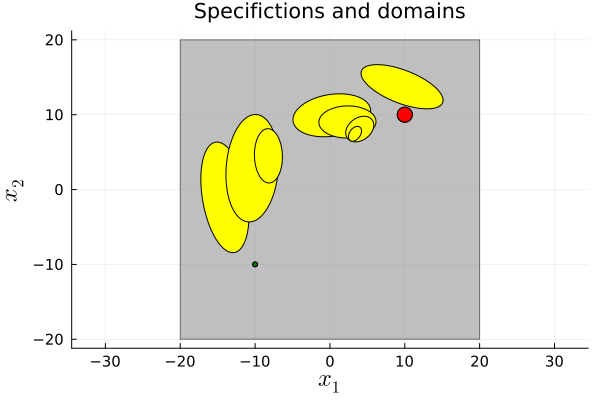

In [8]:
fig = plot(;
    aspect_ratio = :equal,
    xtickfontsize = 10,
    ytickfontsize = 10,
    guidefontsize = 16,
    titlefontsize = 14,
    label = false,
);
xlabel!("\$x_1\$");
ylabel!("\$x_2\$");
title!("Specifictions and domains");

#Display the concrete domain
plot!(concrete_system.X; color = :grey, opacity = 0.5, label = false);

#Display the abstract domain
plot!(abstract_system; arrowsB = false, cost = false, label = false);

#Display the concrete specifications
plot!(concrete_problem.initial_set; color = :green, label = false);
plot!(concrete_problem.target_set; color = :red, label = false)

# Display the abstraction

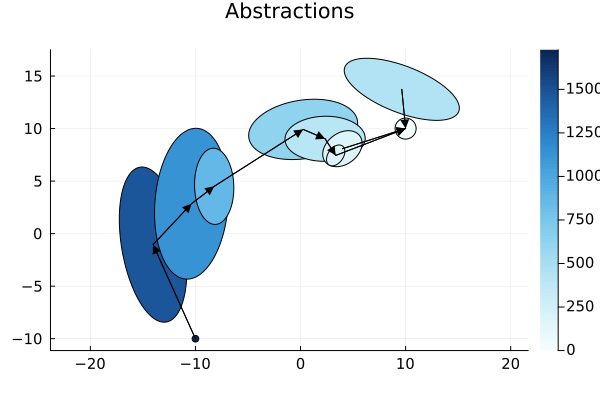

In [9]:
fig = plot(;
    aspect_ratio = :equal,
    xtickfontsize = 10,
    ytickfontsize = 10,
    guidefontsize = 16,
    titlefontsize = 14,
);
title!("Abstractions");
plot!(abstract_system; arrowsB = true)

# Display the Lyapunov function and the trajectory

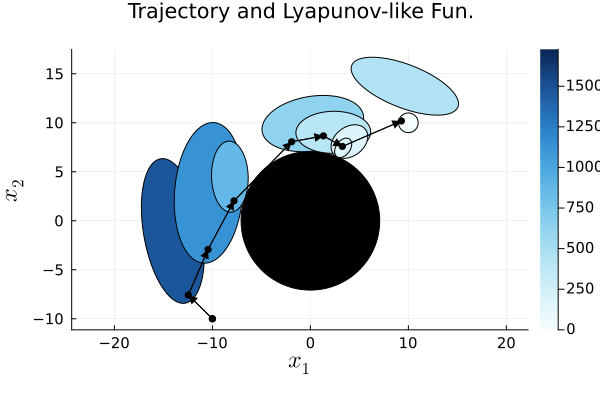

In [10]:
fig = plot(;
    aspect_ratio = :equal,
    xtickfontsize = 10,
    ytickfontsize = 10,
    guidefontsize = 16,
    titlefontsize = 14,
);
xlabel!("\$x_1\$");
ylabel!("\$x_2\$");
title!("Trajectory and Lyapunov-like Fun.");

for obs in concrete_system.obstacles
    plot!(obs; color = :black)
end
plot!(abstract_system; arrowsB = false, cost = true);
plot!(cost_control_trajectory; color = :black)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*